In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lineticks import LineTicks
from scipy.optimize import minimize

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Introduction

In this document, I want to look at the plot of EY vs. brew ratio, and in particular I want to look at how that plot is influenced by changes in extraction parameters.

Let's build a class to handle the modeling:

In [3]:
class Model(object):
    def __init__(self, rate=250., time=250.):
        self.a_l = 0.2
        self.a_s1 = 0.5
        self.a_s2 = 0.3

        self.Q = rate / (1e2)**3 / 60.
        self.A = np.pi * (59e-3 / 2)**2
        self.v_l = self.Q / (self.a_l * self.A)

        self.L = 0.0405
        self.N = 100
        self.dz = self.L / self.N

        self.d_s1 = 2.517e-5
        self.d_s2 = 5.63e-4

        self.rho_l = 965.3
        self.h_sl1 = 5.1207e-4 / self.rho_l
        self.h_sl2 = 1.43e-3 / self.rho_l

        self.D_v1 = self.d_s1 * self.h_sl1
        self.D_v2 = self.d_s2 * self.h_sl2

        self.phi_v1 = 0.56
        self.phi_v2 = 0.56

        self.dt = 0.05
        self.num_t = round(time / self.dt)

        self.c_s = 358.587

        self.args = (self.v_l, self.dz, self.D_v1, self.D_v2, self.a_s1, self.a_l, self.d_s1, self.a_s2, self.d_s2, self.phi_v1, self.phi_v2)
        self.args_without_flow = (0., self.dz, self.D_v1, self.D_v2, self.a_s1, self.a_l, self.d_s1, self.a_s2, self.d_s2, self.phi_v1, self.phi_v2)

    @staticmethod
    def Ai(D_v, a_s, a_l, d_s):
        return (6. * D_v * a_s) / (a_l * d_s**2)

    @staticmethod
    def G(D_v, a_s, a_l, d_s, c_s, c_l):
        return Model.Ai(D_v, a_s, a_l, d_s) * (c_s - c_l)

    @staticmethod
    def H(D_v, phi_v, d_s, c_s, c_l):
        return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

    @staticmethod
    def update(y, t, v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2):
        # Parse the interleaved data
        c_l = y[::3]
        c_s1 = y[1::3]
        c_s2 = y[2::3]

        # Initialize the return value
        dy_dt = np.empty_like(y)

        # Interleaved views of the return value
        dcl_dt = dy_dt[::3]
        dcs1_dt = dy_dt[1::3]
        dcs2_dt = dy_dt[2::3]

        # Compute derivatives
        dcl_dt[0] = -v_l * c_l[0] / dz + \
            Model.G(D_v1, a_s1, a_l, d_s1, c_s1[0], c_l[0]) + \
            Model.G(D_v2, a_s2, a_l, d_s2, c_s2[0], c_l[0])
        dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
            Model.G(D_v1, a_s1, a_l, d_s1, c_s1[1:], c_l[1:]) + \
            Model.G(D_v2, a_s2, a_l, d_s2, c_s2[1:], c_l[1:])

        dcs1_dt[:] = -Model.H(D_v1, phi_v1, d_s1, c_s1, c_l)
        dcs2_dt[:] = -Model.H(D_v2, phi_v2, d_s2, c_s2, c_l)

        return dy_dt
    
    def initial_conditions(self):
        # Initial values
        cl_0 = np.array([0.] * self.N)
        cs1_0 = np.array([self.c_s] * self.N)
        cs2_0 = np.array([self.c_s] * self.N)

        y0 = np.empty(3 * self.N)
        y0[::3] = cl_0
        y0[1::3] = cs1_0
        y0[2::3] = cs2_0

        # Time step for initialization
        dt_init = self.dz / self.v_l
        t_init = np.linspace(-self.N * dt_init, 0., self.N + 1)

        for i in range(len(t_init)):
            # Advance the fluid
            c_l = y0[::3]
            c_l[1:] = c_l[:-1]
            c_l[0] = 0.

            # Update with no flow
            sol = odeint(Model.update, y0, t_init[i:i+2], self.args_without_flow, ml=3, mu=2)
            y0[:i*3] = sol[-1][:i*3]

        return y0
    
    def run_model(self):
        # Initial conditions
        y0 = self.initial_conditions()

        # Simulation time
        t = np.linspace(0., self.num_t * self.dt, self.num_t)

        # Model the shot
        sol = odeint(Model.update, y0, t, self.args, ml=3, mu=2)

        return t, sol
    
    def do_plot(self, ax, t, sol):
        # Get values at the outlet
        c_l = sol[:,-3]

        # Integrate to get mass of solubles and liquid
        in_s = 0.06
        out_s = np.cumsum(self.Q * (c_l[1:] + c_l[:-1]) / 2. * self.dt)
        out_l = self.Q * 1e3 * t[1:]

        # Plot the values
        traj, = ax.plot((out_l + out_s) / in_s, 100. * out_s / in_s)

        # Label the axes
        ax.set_xlabel('Brew Ratio')
        ax.set_ylabel('Extraction Yield (%)')

        # Set axis limits
        plt.xlim([-2.5, 20.])
        plt.ylim([-1., 35.])

        # Draw ticks to indicate time
        n = len(out_s)
        major_ticks = LineTicks(traj, range(0, 901, 100), 10, lw=1, label=['{:.0f}'.format(round(tt)) for tt in t[::100]])
        major_ticks = LineTicks(traj, range(901, n, 100), 10, lw=1)
        # major_ticks = LineTicks(traj, range(0, n, 100), 10, lw=1)
        minor_ticks = LineTicks(traj, range(0, n, 20), 4, lw=1)

Let's give it a whirl.

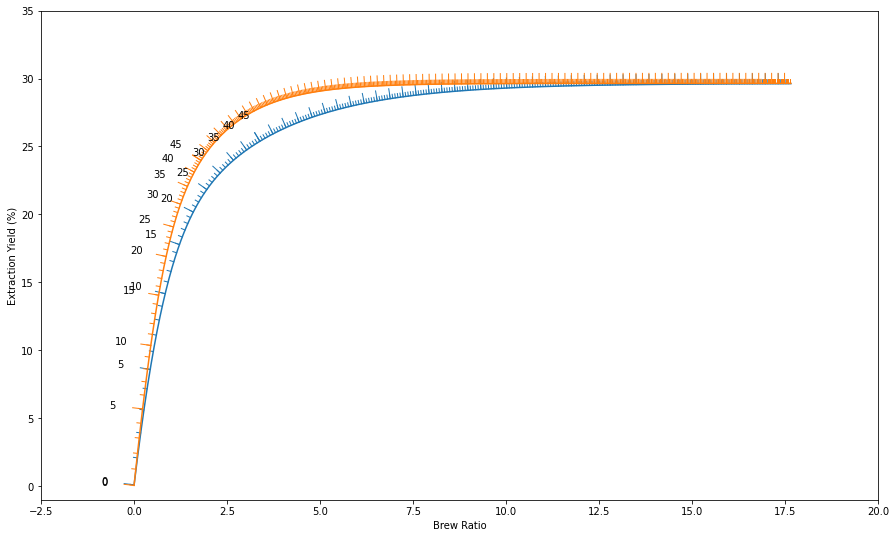

In [4]:
fig, ax = plt.subplots(figsize=(15,9))

model = Model(rate=250., time=250.)
t, sol = model.run_model()
model.do_plot(ax, t, sol)

model = Model(rate=125., time=500.)
t, sol = model.run_model()
model.do_plot(ax, t, sol)

Can we fit this with an exponential? First, let's get the data points.

In [5]:
# Model
model = Model(rate=250., time=250.)
t, sol = model.run_model()

# Get values at the outlet
c_l = sol[:,-3]

# Integrate to get mass of solubles and liquid
in_s = 0.06
out_s = np.cumsum(model.Q * (c_l[1:] + c_l[:-1]) / 2. * model.dt)
out_l = model.Q * 1e3 * t[1:]

# Get the values
brew_ratio = (out_l + out_s) / in_s
ey = 100. * out_s / in_s

Now we set up the optimization.

In [6]:
def func(t, m, tau):
    return m * (1 - np.exp(-t/tau))

def error(x, t, ey, m_i, tau_i):
    return sum((ey - func(t, x[m_i], x[tau_i]))**2)

def get_fit(t, ey):
    # Initial values for optimization parameters
    m_0 = np.array([1.])
    tau_0 = np.array([1.])
    
    # Indices for optimization parameters
    m_i = [0] * len(t)
    tau_i = [1] * len(t)
    
    # Optimization parameter array
    x0 = np.concatenate([m_0, tau_0])
    
    # Optimize
    return minimize(error, x0, args=(t, ey, m_i, tau_i), method='BFGS')

And run it.

In [7]:
# Calculate best fit
res = get_fit(brew_ratio, ey)
print(res)

# Get fit parameters
fit_m = res.x[0]
fit_tau = res.x[1]

<ipython-input-6-928d32715a7f>:5: RuntimeWarning: overflow encountered in square
  return sum((ey - func(t, x[m_i], x[tau_i]))**2)
<ipython-input-6-928d32715a7f>:5: RuntimeWarning: overflow encountered in double_scalars
  return sum((ey - func(t, x[m_i], x[tau_i]))**2)
c:\python39\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1657.8561555358883
 hess_inv: array([[1.72234540e-07, 1.14823027e-07],
       [1.14823027e-07, 7.65583856e-08]])
      jac: array([0.00064087, 0.00022888])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 160
      nit: 15
     njev: 52
   status: 2
  success: False
        x: array([29.18440781,  1.46216957])


Now we plot the results.

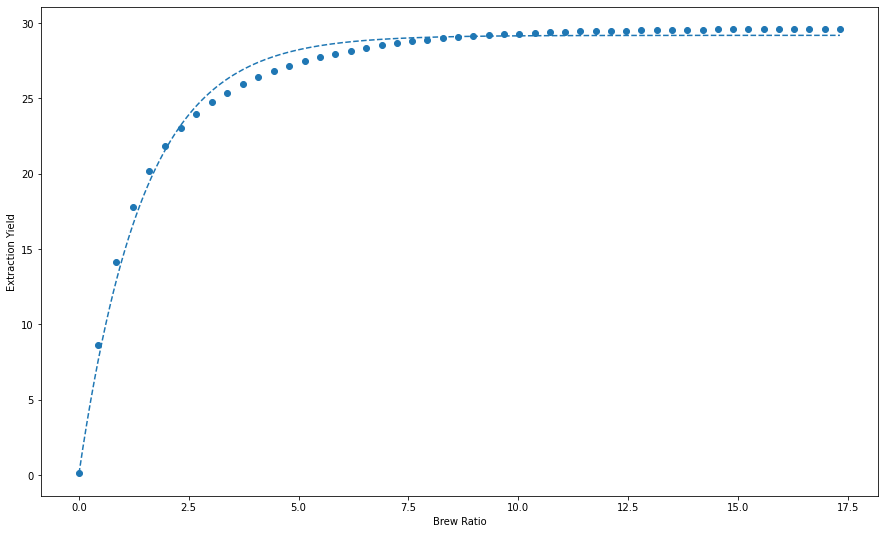

In [8]:
def plot_single(ax, xs, ys, m, tau):
    # Draw data points
    sc = ax.scatter(xs, ys)
    
    # Draw the fit
    xs_fit = np.linspace(min(xs), max(xs), num=200)
    ys_fit = func(xs_fit, m, tau,)
    
    ax.plot(xs_fit, ys_fit, '--')

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot this configuration
plot_single(ax, brew_ratio[::100], ey[::100], fit_m, fit_tau)

What if we use the sum of two exponentials?

      fun: 21.31632282460389
 hess_inv: array([[ 8.36568059e-04,  2.56274358e-05, -4.16470384e-04,
         3.93237552e-04],
       [ 2.56274358e-05,  2.97199769e-05, -2.33456908e-05,
        -7.19369368e-06],
       [-4.16470384e-04, -2.33456908e-05,  2.46015785e-04,
        -2.21653081e-04],
       [ 3.93237552e-04, -7.19369368e-06, -2.21653081e-04,
         2.71918801e-04]])
      jac: array([-7.15255737e-07,  7.39097595e-06,  5.96046448e-06,  4.05311584e-06])
  message: 'Optimization terminated successfully.'
     nfev: 350
      nit: 18
     njev: 68
   status: 0
  success: True
        x: array([17.31317349,  0.81785663, 12.37425669,  2.95407374])


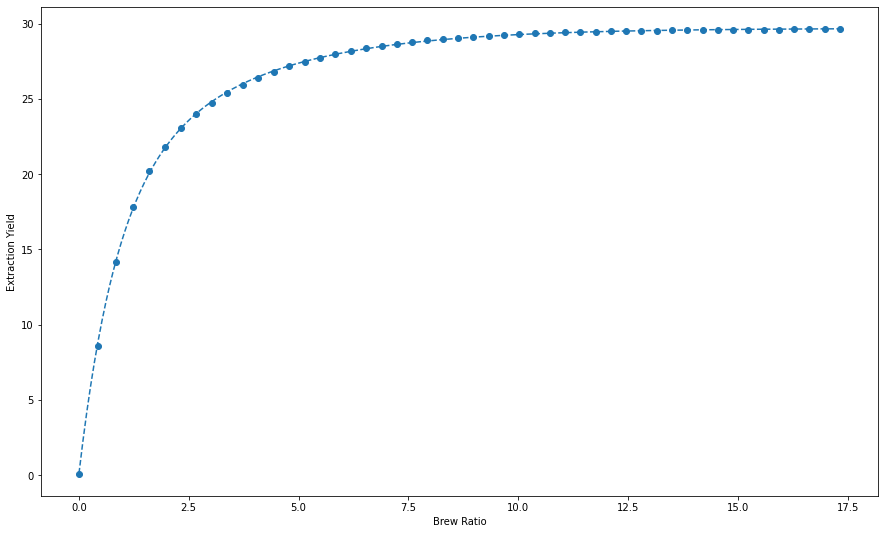

In [9]:
def func_2(t, m_1, tau_1, m_2, tau_2):
    return m_1 * (1 - np.exp(-t/tau_1)) + m_2 * (1 - np.exp(-t/tau_2))

def error_2(x, t, ey, m_1_i, tau_1_i, m_2_i, tau_2_i):
    return sum((ey - func_2(t, x[m_1_i], x[tau_1_i], x[m_2_i], x[tau_2_i]))**2)

def get_fit_2(t, ey):
    # Initial values for optimization parameters
    m_1_0 = np.array([15.])
    tau_1_0 = np.array([0.5])
    m_2_0 = np.array([15.])
    tau_2_0 = np.array([3.0])
    
    # Indices for optimization parameters
    m_1_i = [0] * len(t)
    tau_1_i = [1] * len(t)
    m_2_i = [2] * len(t)
    tau_2_i = [3] * len(t)
    
    # Optimization parameter array
    x0 = np.concatenate([m_1_0, tau_1_0, m_2_0, tau_2_0])
    
    # Optimize
    return minimize(error_2, x0, args=(t, ey, m_1_i, tau_1_i, m_2_i, tau_2_i), method='BFGS')

# Calculate best fit
res = get_fit_2(brew_ratio, ey)
print(res)

# Get fit parameters
fit_m_1 = res.x[0]
fit_tau_1 = res.x[1]
fit_m_2 = res.x[2]
fit_tau_2 = res.x[3]

def plot_single_2(ax, xs, ys, m_1, tau_1, m_2, tau_2):
    # Draw data points
    sc = ax.scatter(xs, ys)
    
    # Draw the fit
    xs_fit = np.linspace(min(xs), max(xs), num=200)
    ys_fit = func_2(xs_fit, m_1, tau_1, m_2, tau_2)
    
    ax.plot(xs_fit, ys_fit, '--')

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot this configuration
plot_single_2(ax, brew_ratio[::100], ey[::100], fit_m_1, fit_tau_1, fit_m_2, fit_tau_2)

That's a lot better.